<a href="https://colab.research.google.com/github/candanbayar/2022352_ID_Wordle_Twitter_Dataset_/blob/main/Big_Data_Wordle_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Packages

In [1]:
# pyspark 

!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=c6d1fc86ba5e1a040ef35a50d85a650d9df859fee9b35f62522baae348e0f073
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [2]:
!pip install -U textblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Libraries

In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt   
from itertools import cycle
import re 

# import libraries about NLP 
import warnings
warnings.simplefilter("ignore")

import re
import numpy as np 
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

import gensim  
import nltk 
from nltk.sentiment import SentimentIntensityAnalyzer 
from textblob import TextBlob 
from wordcloud import WordCloud, STOPWORDS 

from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer

import tensorflow as tf
import plotly.express as px 

# Modelling 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# import keras 

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

In [4]:
# import pyspark

from pyspark.sql import SparkSession

In [6]:
# create variable called spark 

spark = SparkSession.builder.appName('wordle_tweet').getOrCreate()

In [7]:
# spark 

spark

In [8]:
tw = spark.read.csv("tweets_wordle.csv")

In [9]:
tw

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string]

In [10]:
# read the dataset 

spark.read.option('header','true').csv('tweets_wordle.csv').show()

+-----------+-------------------+--------------------+--------------+--------------+
|  wordle_id|           tweet_id|          tweet_date|tweet_username|    tweet_text|
+-----------+-------------------+--------------------+--------------+--------------+
|        210|1482553374591660037|2022-01-16 03:20:...|      bpszebes|Wordle 210 4/6|
|    ⬛⬛🟨🟨⬛|               null|                null|          null|          null|
|     🟩⬛⬛⬛⬛|               null|                null|          null|          null|
|   🟩🟩🟨⬛⬛|               null|                null|          null|          null|
|🟩🟩🟩🟩🟩"|               null|                null|          null|          null|
|        210|1482553387937898499|2022-01-16 03:20:...|    cruisecoup|Wordle 210 4/6|
|      ⬜⬜⬜⬜⬜|               null|                null|          null|          null|
|  🟩🟩🟨🟨⬜|               null|                null|          null|          null|
|  🟩🟩⬜🟩🟨|               null|                null|          null|          null|

In [11]:
# type dataset 
type(tw)

pyspark.sql.dataframe.DataFrame

In [12]:
# check the schema 

tw.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)



In [13]:
# read dataset 

tw = pd.read_csv("tweets_wordle.csv")

In [14]:
tw.dtypes

wordle_id          int64
tweet_id           int64
tweet_date        object
tweet_username    object
tweet_text        object
dtype: object

In [15]:
tw.head()

,wordle_id,tweet_id,tweet_date,tweet_username,tweet_text
0,210,1482553374591660037,2022-01-16 03:20:43+00:00,bpszebes,Wordle 210 4/6\n\n⬛⬛🟨🟨⬛\n🟩⬛⬛⬛⬛\n🟩🟩🟨⬛⬛\n🟩🟩🟩🟩🟩
1,210,1482553387937898499,2022-01-16 03:20:46+00:00,cruisecoup,Wordle 210 4/6\n\n⬜⬜⬜⬜⬜\n🟩🟩🟨🟨⬜\n🟩🟩⬜🟩🟨\n🟩🟩🟩🟩🟩
2,210,1482553422276698113,2022-01-16 03:20:55+00:00,DestroVega,Wordle 210 4/6\n\n⬜⬜⬜🟨⬜\n⬜🟩⬜🟨⬜\n⬜🟩⬜🟨⬜\n🟩🟩🟩🟩🟩
3,210,1482553436910628866,2022-01-16 03:20:58+00:00,brenmardash,Wordle 210 3/6\n\n⬜⬜🟨⬜⬜\n🟨🟨⬜⬜⬜\n🟩🟩🟩🟩🟩
4,210,1482553445726908420,2022-01-16 03:21:00+00:00,KatieHowse2,Wordle 210 3/6\n\n⬛⬛🟨⬛⬛\n🟩🟩🟩⬛⬛\n🟩🟩🟩🟩🟩


# Word Cloud

In [16]:
# word cloud 

#Make a word Cloud from dataset
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [17]:
def show_wordcloud(data, title=""):
    text = " ".join(t for t in data.dropna())
    stopwords = set(STOPWORDS)
    stopwords.update(["t", "co", "https", "amp", "U"])
    wordcloud = WordCloud(stopwords=stopwords, scale=4, max_font_size=40, max_words=700,background_color="#002210").generate(text)
    fig = plt.figure(1, figsize=(20,20))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.style.use('ggplot')
    plt.show()

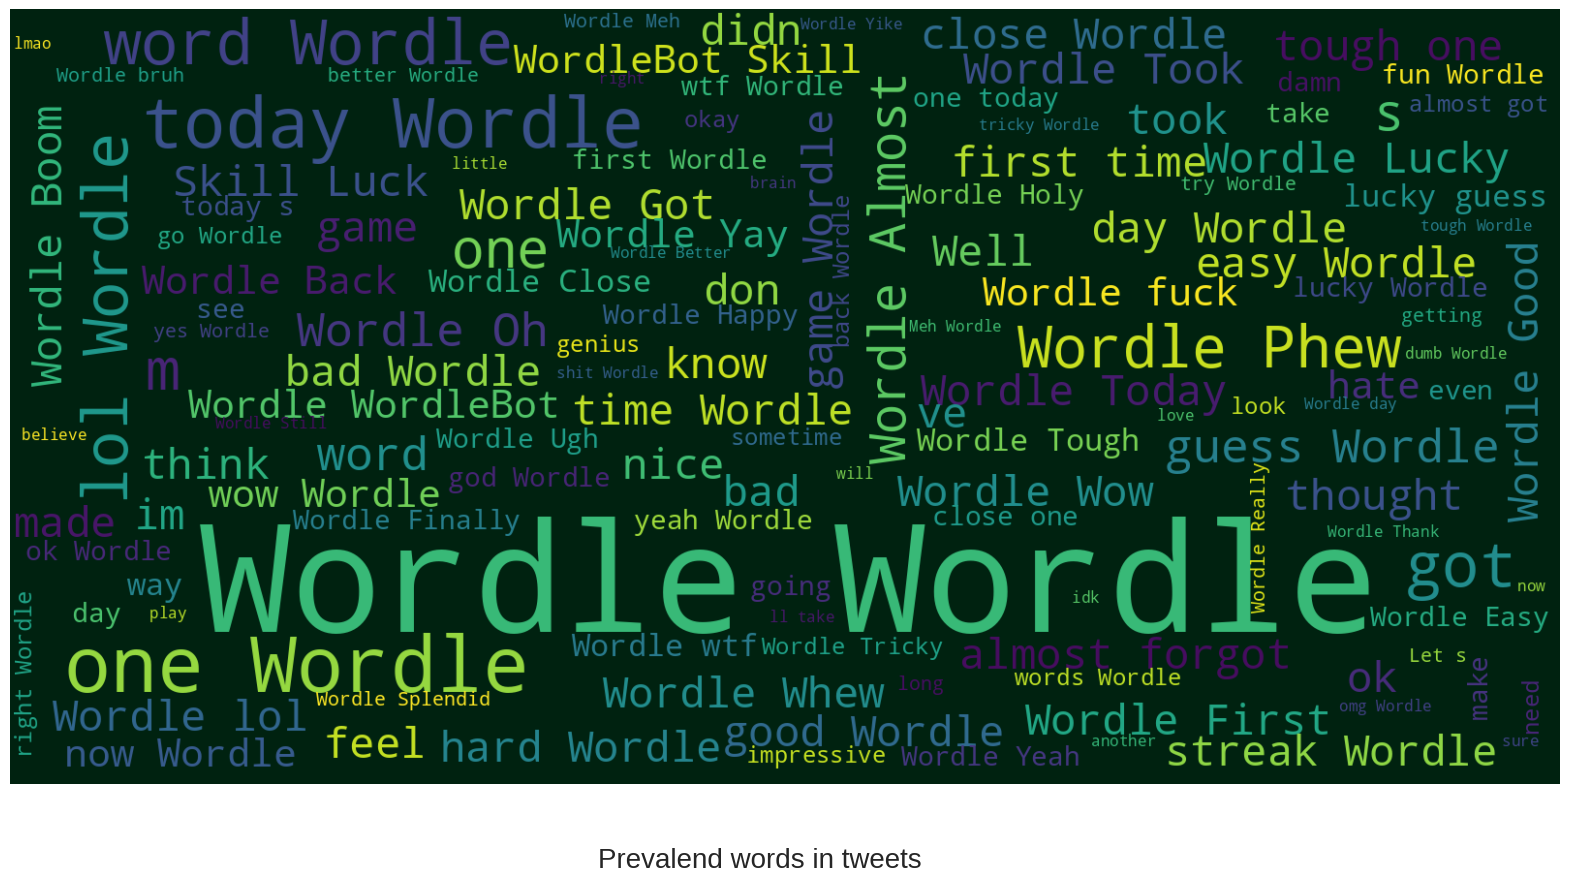

In [18]:
show_wordcloud(tw['tweet_text'] , title = 'Prevalend words in tweets')

### Hastag Analysis

In [20]:
# analysis to hastag 
def plot_features_(features, title, tw, isLog=False):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        if(isLog):
            sns.distplot(np.log1p(tw[feature]),kde=True,hist=False, bins=120, label=feature,color='blue')
        else:
            sns.distplot(tw[feature],kde=True, hist=False, bins=120, label=feature,color='blue')
    plt.xlabel('')
    plt.legend()
    plt.show();

### Pre Processing of Dataset

In [21]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [22]:
temp = []
#Splitting pd.Series to list
data_to_list = tw["tweet_text"].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['Wordle 210 4/6 ⬛⬛🟨🟨⬛ 🟩⬛⬛⬛⬛ 🟩🟩🟨⬛⬛ 🟩🟩🟩🟩🟩',
 'Wordle 210 4/6 ⬜⬜⬜⬜⬜ 🟩🟩🟨🟨⬜ 🟩🟩⬜🟩🟨 🟩🟩🟩🟩🟩',
 'Wordle 210 4/6 ⬜⬜⬜🟨⬜ ⬜🟩⬜🟨⬜ ⬜🟩⬜🟨⬜ 🟩🟩🟩🟩🟩',
 'Wordle 210 3/6 ⬜⬜🟨⬜⬜ 🟨🟨⬜⬜⬜ 🟩🟩🟩🟩🟩',
 'Wordle 210 3/6 ⬛⬛🟨⬛⬛ 🟩🟩🟩⬛⬛ 🟩🟩🟩🟩🟩']

In [23]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        

data_words = list(sent_to_words(temp))
print(data_words[:10],'\n')

[['wordle'], ['wordle'], ['wordle'], ['wordle'], ['wordle'], ['wordle'], ['wordle'], ['wordle'], ['wordle', 'got', 'lucky', 'lol'], ['wordle']] 



In [24]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['wordle', 'wordle', 'wordle', 'wordle', 'wordle']


### Sentiment Analysis

In [25]:
# make sentiment analysis positive , negative and neutral 
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
def find_sentiment(post):
    if sia.polarity_scores(post)["compound"] > 0:
        return "Positive"
    elif sia.polarity_scores(post)["compound"] < 0:
        return "Negative"
    else:
        return "Neutral" 

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [26]:
tw['sentiment'] = tw['tweet_text'].apply(lambda x: find_sentiment(x))
tw.head(10)

,wordle_id,tweet_id,tweet_date,tweet_username,tweet_text,sentiment
0,210,1482553374591660037,2022-01-16 03:20:43+00:00,bpszebes,Wordle 210 4/6\n\n⬛⬛🟨🟨⬛\n🟩⬛⬛⬛⬛\n🟩🟩🟨⬛⬛\n🟩🟩🟩🟩🟩,Neutral
1,210,1482553387937898499,2022-01-16 03:20:46+00:00,cruisecoup,Wordle 210 4/6\n\n⬜⬜⬜⬜⬜\n🟩🟩🟨🟨⬜\n🟩🟩⬜🟩🟨\n🟩🟩🟩🟩🟩,Neutral
2,210,1482553422276698113,2022-01-16 03:20:55+00:00,DestroVega,Wordle 210 4/6\n\n⬜⬜⬜🟨⬜\n⬜🟩⬜🟨⬜\n⬜🟩⬜🟨⬜\n🟩🟩🟩🟩🟩,Neutral
3,210,1482553436910628866,2022-01-16 03:20:58+00:00,brenmardash,Wordle 210 3/6\n\n⬜⬜🟨⬜⬜\n🟨🟨⬜⬜⬜\n🟩🟩🟩🟩🟩,Neutral
4,210,1482553445726908420,2022-01-16 03:21:00+00:00,KatieHowse2,Wordle 210 3/6\n\n⬛⬛🟨⬛⬛\n🟩🟩🟩⬛⬛\n🟩🟩🟩🟩🟩,Neutral
5,210,1482553448025395202,2022-01-16 03:21:01+00:00,iconoco,Wordle 210 4/6\n\n⬛⬛⬛🟨⬛\n🟨🟨⬛🟨⬛\n⬛🟩🟩⬛⬛\n🟩🟩🟩🟩🟩,Neutral
6,210,1482553451439603720,2022-01-16 03:21:01+00:00,ParickHarmon,Wordle 210 3/6\n\n🟨⬜⬜🟩⬜\n⬜🟨🟨🟨⬜\n🟩🟩🟩🟩🟩,Neutral
7,210,1482553460251709443,2022-01-16 03:21:04+00:00,Revnan2001,Wordle 210 4/6\n\n⬜⬜🟨⬜⬜\n⬜⬜⬜🟨⬜\n🟩🟨⬜⬜🟨\n🟩🟩🟩🟩🟩,Neutral
8,210,1482553474243981312,2022-01-16 03:21:07+00:00,sarajmun,Wordle 210 2/6\n\n🟨🟩⬛🟩🟨\n🟩🟩🟩🟩🟩\n\nGot lucky lol,Positive
9,210,1482553491050700800,2022-01-16 03:21:11+00:00,CraigBatts,Wordle 210 2/6\n\n⬜🟩🟨⬜⬜\n🟩🟩🟩🟩🟩,Neutral


Encoding

In [27]:
# Label Encoding
labels = np.array(tw["sentiment"])
y = []
for i in range(len(labels)):
    if labels[i] == 'Neutral':
        y.append(0)
    if labels[i] == 'Negative':
        y.append(1)
    if labels[i] == "Positive":
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [28]:
# total sentiment analysis and show plotly 

def plot_sentiment(tw, feature, title):
    counts = tw[feature].value_counts()
    percent = counts/sum(counts)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

    counts.plot(kind='bar', ax=ax1, color='red')
    percent.plot(kind='bar', ax=ax2, color='blue')
    ax1.set_ylabel(f'Counts : {title} sentiments', size=12)
    ax2.set_ylabel(f'Percentage : {title} sentiments', size=12)
    plt.suptitle(f"Sentiment analysis: {title}\n")  
    plt.tight_layout()
    plt.show()

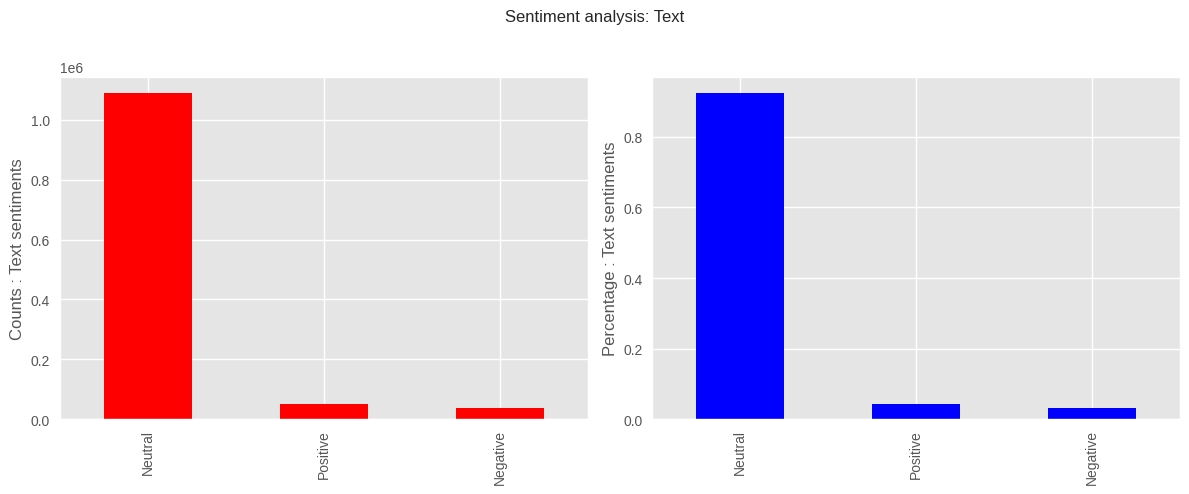

In [29]:
# visiualisiation 

plot_sentiment(tw, 'sentiment', 'Text')